In [1]:
import numpy as np
import cv2
from PIL import Image,ImageDraw
import matplotlib.pyplot as plt
import math
import copy
import sys

In [2]:
sobel_X=np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
sobel_Y=np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
count=0
threshold_val=[0.002,0.001,0.05,0.05,0.05]
image_list=['buildingGray.jpg','rose.jpg','lena.jpg','bicycle.bmp','Image_fig2.jpg']

In [3]:
def rgb2gray(image):
    '''
    Converts Color Image (RGB) to GrayScale Image
    '''
    
    gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    return gray

In [4]:
def display_image(arr):
    '''
    Displays Image
    '''

    image_harris=Image.fromarray(arr)
    # Display the image
    image_harris.show()

In [5]:
def gaussian_smoothing(sigma=1,mean=0):
    '''
    Returns a Gaussian Mask
    
    Arguments:
    sigma -- Default value -> 1
    mean -- Default value -> 0
    
    Returns:
    gaussian_filter -- numpy array of size (2*sigma+1,2*sigma+1)
    '''
    # radius of the gaussian curve
    radius=int(sigma)
    # X and Y values
    X=np.linspace(-radius,radius,2*radius+1)
    Y=np.linspace(-radius,radius,2*radius+1)
    
    [grid_X,grid_Y]=np.meshgrid(X,Y)
    
    #gaussian_filter=np.exp(-(grid_X**2+grid_Y**2)/(2*(sigma)**2))/(math.sqrt(2*math.pi)*sigma)
    
    # Gaussian Mask
    gaussian_filter=np.exp(-(grid_X**2+grid_Y**2-mean**2)/(2*(sigma)**2))
    gaussian_filter=gaussian_filter/np.sum(gaussian_filter)
    
    return gaussian_filter

In [6]:
def add_padding(I,H):
    '''
    This function adds Padding to an Image
    '''
    # Padding to added in row and column
    pad_R=int((H.shape[0]-1)/2)+(H.shape[0]+1)%2
    pad_C=int((H.shape[1]-1)/2)+(H.shape[1]+1)%2

    # Padding of zeros to be added to row and column
    Z_R=np.zeros((pad_R,I.shape[1]))
    if H.shape[0]%2==0:
        Z_C=np.zeros((I.shape[0]+pad_R,pad_C))
    else:
        Z_C=np.zeros((I.shape[0]+2*pad_R,pad_C))

    # If height and width of mask are even
    if H.shape[0]%2==0 and H.shape[1]%2==0:
        I=np.append(Z_R,I,axis=0)
        I=np.append(Z_C,I,axis=1)

    # If height of mask is even and width of mask are odd
    elif H.shape[0]%2==0 and H.shape[1]%2==1:
        I=np.append(Z_R,I,axis=0)
        I=np.concatenate((Z_C,I,Z_C),axis=1)

    # If height of mask is odd and width of mask are even
    elif H.shape[0]%2==1 and H.shape[1]%2==0:
        I=np.concatenate((Z_R,I,Z_R),axis=0)
        I=np.append(Z_C,I,axis=1)

    # If height and width of mask are odd
    else:
        I=np.concatenate((Z_R,I,Z_R),axis=0)
        I=np.concatenate((Z_C,I,Z_C),axis=1)
    
    return I

In [7]:
def convolution(img,H):
    '''
    Performs Convolution Operation
    '''
    # Adds padding to the image
    I_pad=add_padding(img,H)
    
    # convolution array
    conv=np.zeros(img.shape)
    # Mask is inverted about X and then about Y
    H=np.rot90(np.rot90(H))
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            # Window in the image
            window=I_pad[i:i+H.shape[0],j:j+H.shape[1]]
            conv[i,j]=np.sum(window*H)
    
    return conv

In [8]:
def NMR(matrix):
    points=[]
    for k in matrix.keys():
        max_R=0
        for i in range(k[0]-1,k[0]+2):
            for j in range(k[1]-1,k[1]+2):

                if (i,j) in matrix.keys():

                    if matrix[(i,j)]>max_R:
                        pt=(i,j)
                        max_R=matrix[(i,j)]
        if pt not in points:                
            points.append(pt)
    
    return points

In [9]:
def adaptive_NMR(matrix):
    I_sort = dict(sorted(matrix.items(), key=lambda item: item[1],reverse=True))  
    final_pt=[list(I_sort.keys())[0]]
    for i in I_sort.keys():
        for j in final_pt:
            if abs(i[0]-j[0])<=5 and abs(i[1]-j[1])<=5:
                break
        else:
            final_pt.append(i)
    return final_pt

In [10]:
def harris_detector(I,alpha=0.04,method='none',supression='normal',sigm=1):
    '''
    Performs Harris Corner Detector Operation
    '''
    # Checks if the image is colored 
    if len(I.shape)==3:
        # Convertes image to gray scale
        I_gray=rgb2gray(I)
    else:
        I_gray=I 
    print(f'Solving for Image : {image_list[count]}')
    
    print('Performing Gaussian Smoothing')
    gaussian_filter=gaussian_smoothing(sigma=sigm)
    Gaussian=convolution(I_gray,gaussian_filter)
    #Gaussian=cv2.GaussianBlur(I_gray,(3,3),3)

    print('Phase I : Calculating Gradients')
    grad_X=convolution(Gaussian,sobel_X)
    grad_X=convolution(grad_X,gaussian_smoothing(sigma=sigm))
    #grad_X=cv2.GaussianBlur(grad_X,(3,3),1.4)

    grad_Y=convolution(Gaussian,sobel_Y)
    grad_Y=convolution(grad_Y,gaussian_smoothing(sigma=sigm))
    #grad_Y=cv2.GaussianBlur(grad_Y,(3,3),1.4)
    grad_XX=np.square(grad_X)
    grad_YY=np.square(grad_Y)
    grad_XY=np.multiply(grad_X,grad_Y)

    print('Phase II : Calculating R values')
    max_R=0
    mat={}
    for row in range(1,I.shape[0]-1):
        for clm in range(1,I.shape[1]-1):

            Window_XX=np.sum(grad_XX[row-1:row+2,clm-1:clm+2])
            Window_XY=np.sum(grad_XY[row-1:row+2,clm-1:clm+2])
            Window_YY=np.sum(grad_YY[row-1:row+2,clm-1:clm+2])

            M=np.array([[Window_XX,Window_XY],[Window_XY,Window_YY]])

            if method=='none':
                R=np.linalg.det(M)-alpha*(np.trace(M))**2

            elif method=='szeliski':
                R=np.linalg.det(M)/np.trace(M)

            else:
                print('Incorrect Option !!!')
                sys.exit()

            mat[(row,clm)]=R

            if R>max_R:
                max_R=R

    mat_copy=mat.copy()
    threshold=max_R*threshold_val[count]
    for k,v in mat_copy.items():

        if not v>threshold:
            del mat[k]

    print('Phase III : Non Max Supression')
    if supression=='normal':
        points=NMR(mat)

    elif supression=='adaptive':
        points=adaptive_NMR(mat)

    else:
        print('Incorrect Option !!!')
        sys.exit()

    for val in points:
        I=cv2.circle(I,(val[1],val[0]),2,(255,0,0),-1)

    display_image(I)
    plt.imshow(I)
    plt.show()
    # the canvas is saved as an image
    cv2.imwrite(f'Output/output_{image_list[count]}.jpg',cv2.cvtColor(I, cv2.COLOR_BGR2RGB))

Solving for Image : buildingGray.jpg
Performing Gaussian Smoothing
Phase I : Calculating Gradients
Phase II : Calculating R values
Phase III : Non Max Supression


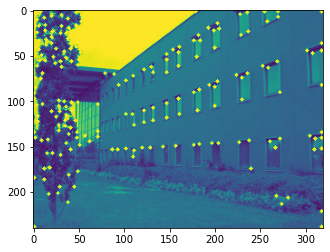

Solving for Image : rose.jpg
Performing Gaussian Smoothing
Phase I : Calculating Gradients
Phase II : Calculating R values
Phase III : Non Max Supression


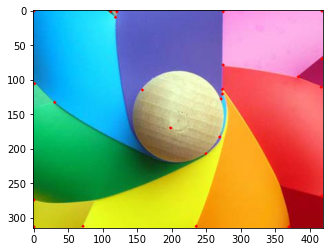

Solving for Image : lena.jpg
Performing Gaussian Smoothing
Phase I : Calculating Gradients
Phase II : Calculating R values
Phase III : Non Max Supression


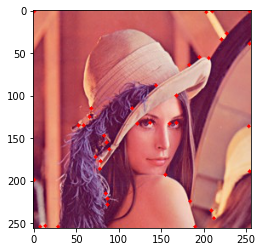

Solving for Image : bicycle.bmp
Performing Gaussian Smoothing
Phase I : Calculating Gradients
Phase II : Calculating R values
Phase III : Non Max Supression


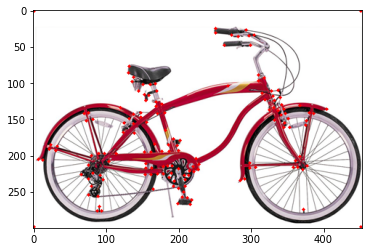

Solving for Image : Image_fig2.jpg
Performing Gaussian Smoothing
Phase I : Calculating Gradients
Phase II : Calculating R values
Phase III : Non Max Supression


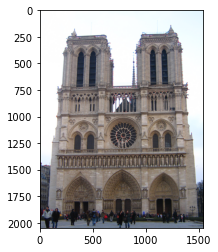

In [11]:
for img in image_list:
    image=Image.open(f'Data/{img}')
    img_arr=np.array(image)
    harris_detector(img_arr,supression='adaptive')
    count+=1